In [1]:
%cd ..

/home/antonbabenko/Projects/newsclass01


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

%config InlineBackend.figure_format = 'retina' 

In [4]:
random_state = 42

In [5]:
data_dir = Path("data")
folds_dir = Path("folds")
train_path = data_dir / "train.csv"

In [6]:
df = pd.read_csv(train_path, index_col="Id")

In [7]:
df.head()

,title,text,images,source
Id,,,,
1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN,5
2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN,3
10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0


In [8]:
df = df[["images", "source"]]

In [9]:
df.head()

,images,source
Id,,
1,NaN,5
2,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
5,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
9,NaN,3
10,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0


In [10]:
image_pathes = []
sources = []
inner_df = df.copy()
inner_df = inner_df.dropna()
for i in range(inner_df.shape[0]):
    images = inner_df.iloc[i, 0]
    source = inner_df.iloc[i, 1]
    
    for image in images.split(","):
        image_pathes.append(image)
        sources.append(source)

In [11]:
df = pd.DataFrame({"image": image_pathes, "source": sources})

## Initial distribution

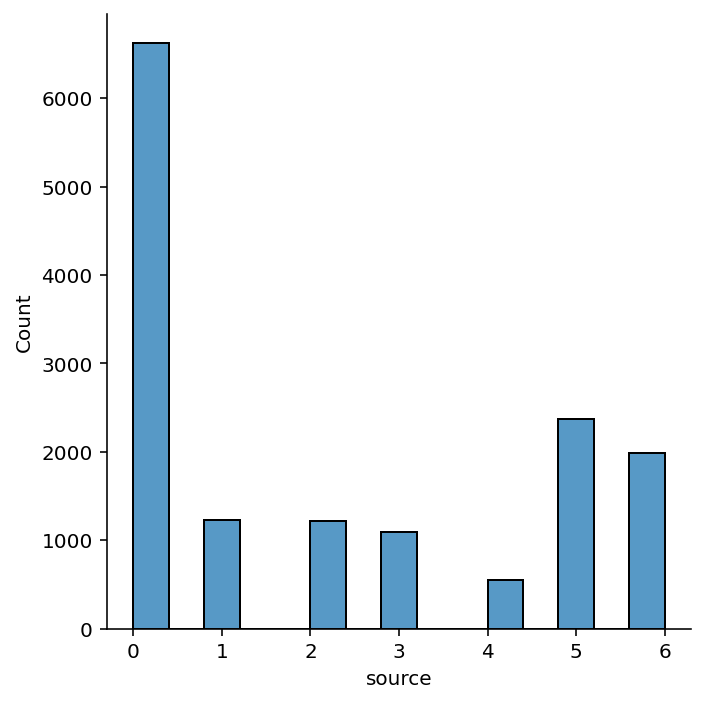

In [12]:
sns.displot(df["source"])

## Stratify

In [13]:
kfold = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)  

In [14]:
target_values = df[["source"]]
splits = kfold.split(df, target_values)

In [15]:
splits

<generator object _BaseKFold.split at 0x7f44e1418f90>

In [16]:
folds = []
for _, test_indexes in splits:
    folds.append(df.iloc[test_indexes])

6


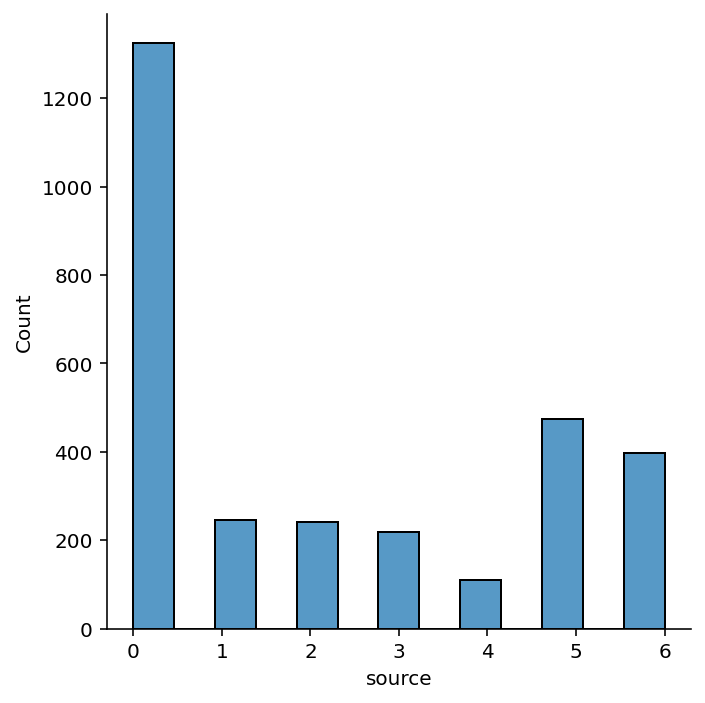

6


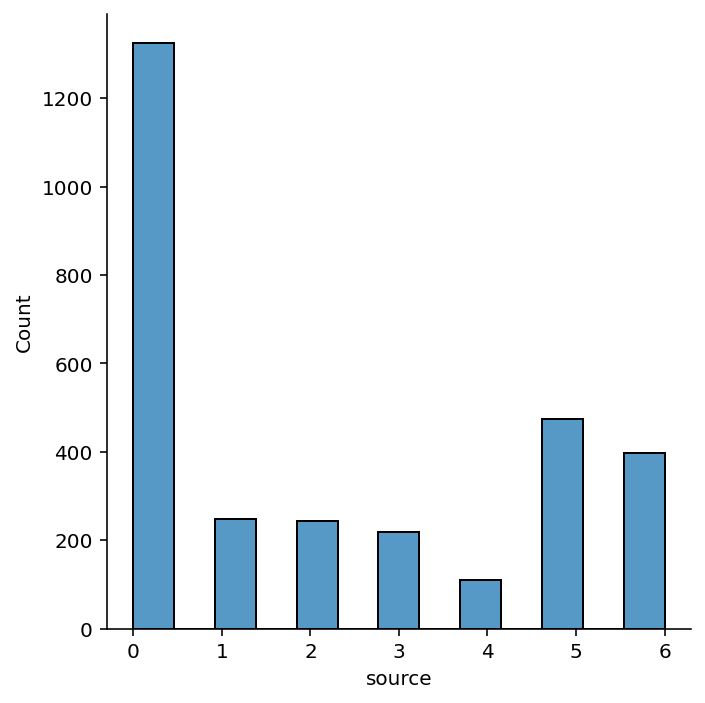

6


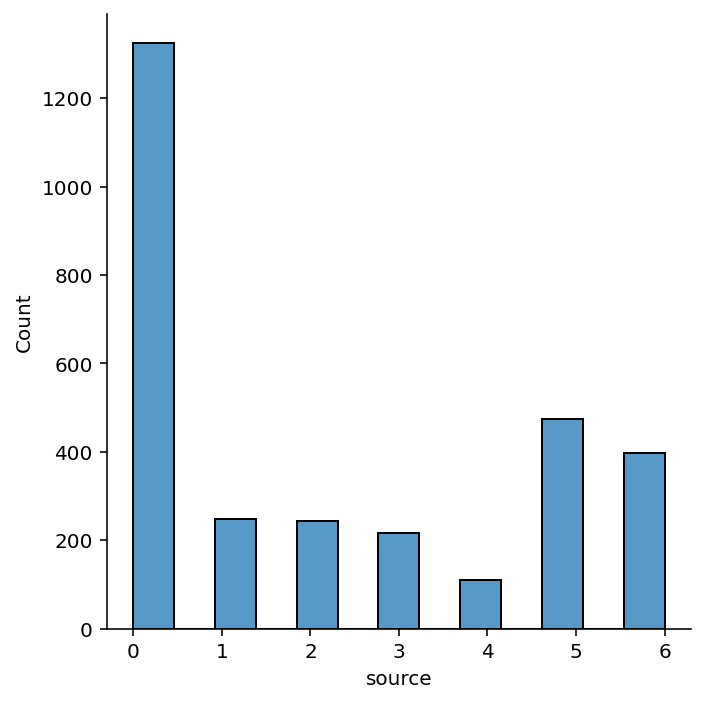

6


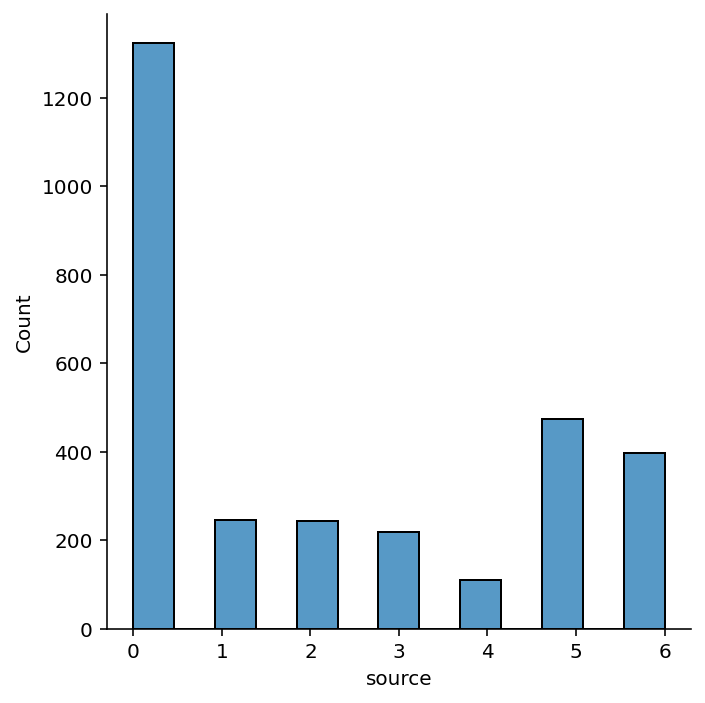

6


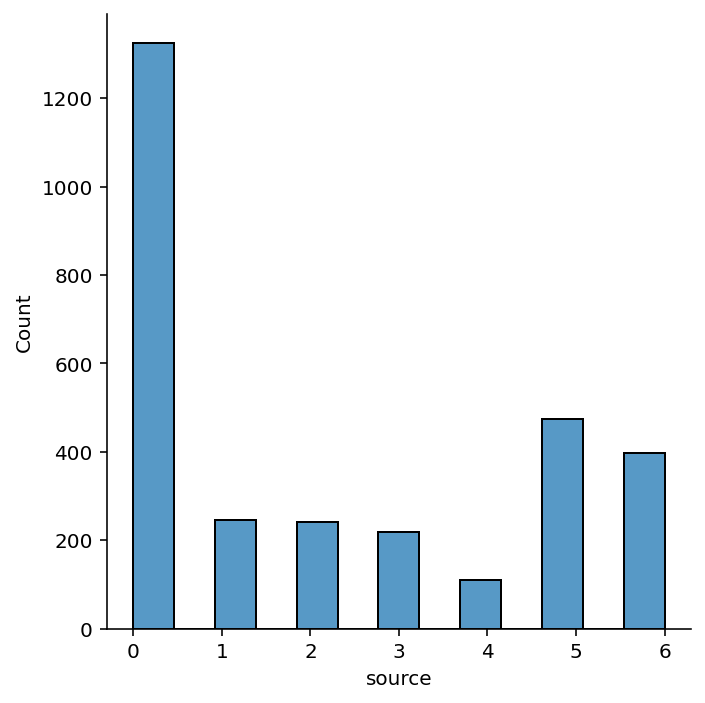

In [17]:
for fold in folds:
    print(max(fold["source"]))
    sns.displot(fold["source"])
    plt.show()

## Post balancing

In [19]:
def upsample(fold, max_value):
    print(fold.shape)
    for label in fold.source.unique():
        values_to_add = max_value - fold[fold.source == label].shape[0]
        
        additional_fold_data = pd.DataFrame()
        
        while values_to_add > 0:
            for i in range(fold.shape[0]):
                if values_to_add == 0:
                    break

                if fold.iloc[i]["source"] == label:
                    additional_fold_data = additional_fold_data.append(fold.iloc[i])
                    values_to_add -= 1
        fold = fold.append(additional_fold_data)
    print(fold.shape)
    return fold

In [20]:
np.max(folds[0].source.value_counts().values)

1325

In [21]:
b_folds = []
for fold in folds:
    b_folds.append(upsample(fold, 600))

(3014, 2)
(4925, 2)
(3014, 2)
(4925, 2)
(3014, 2)
(4925, 2)
(3013, 2)
(4924, 2)
(3013, 2)
(4925, 2)


In [22]:
folds = b_folds

6.0


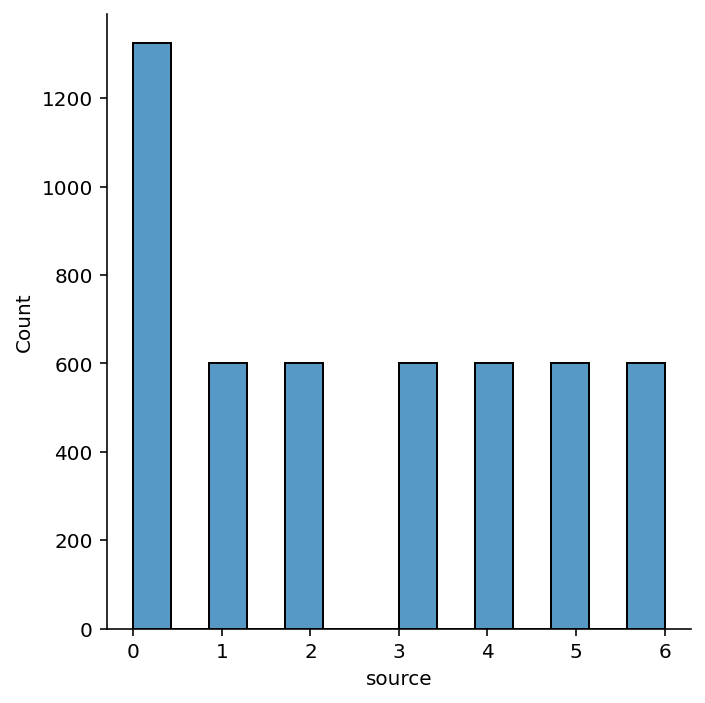

6.0


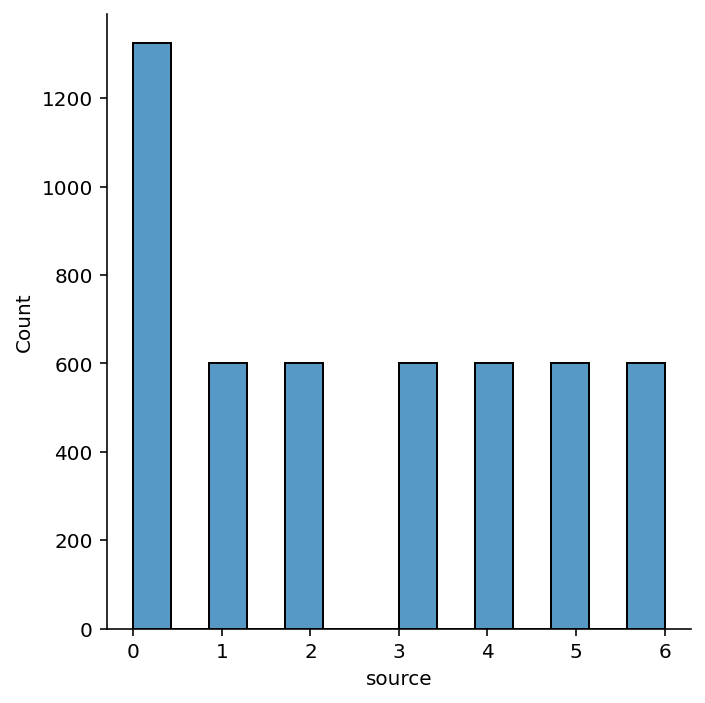

6.0


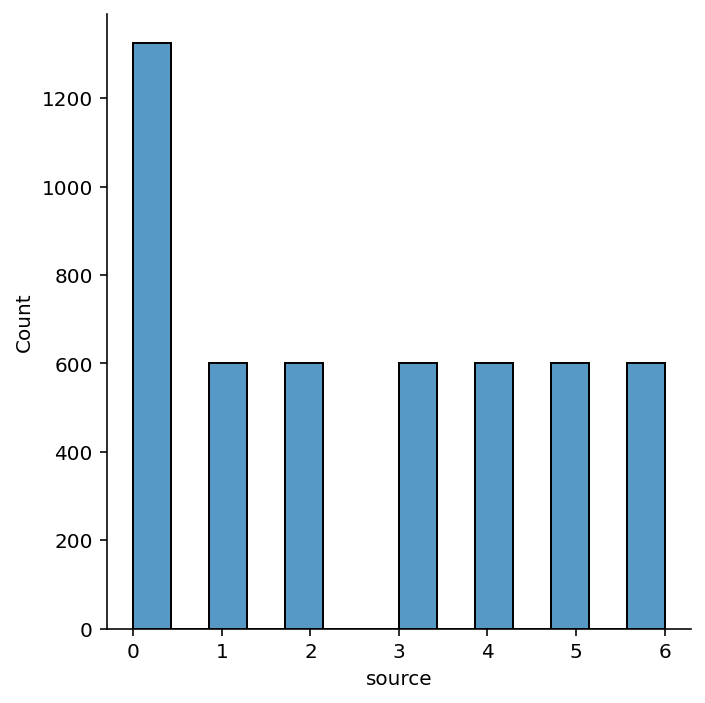

6.0


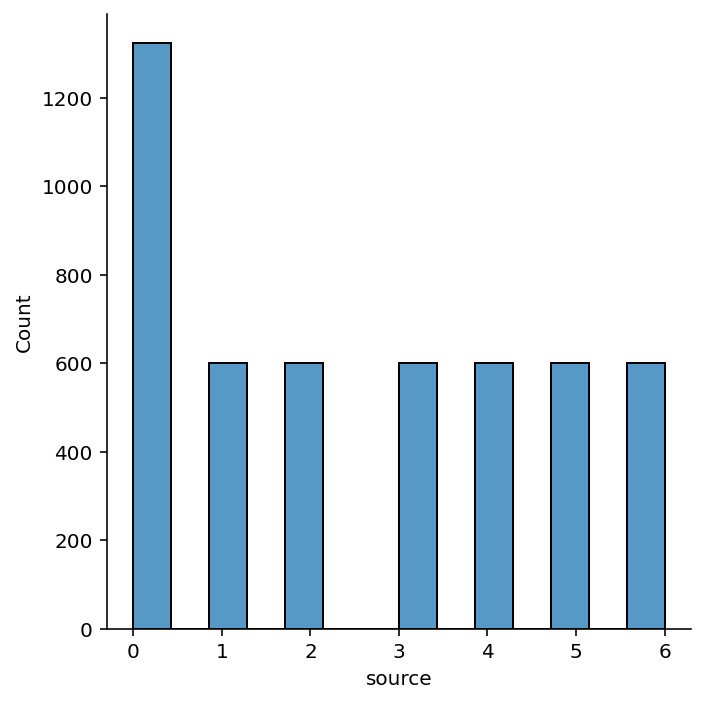

6.0


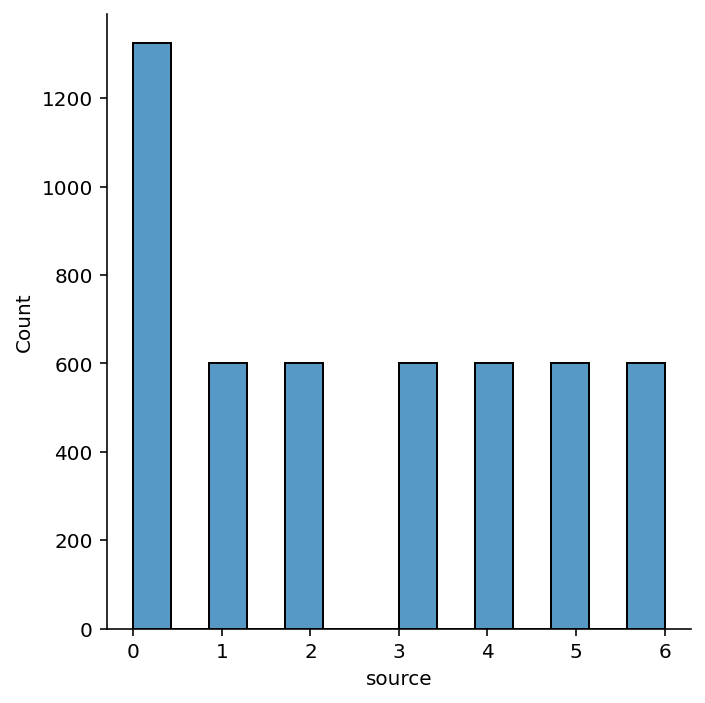

In [23]:
for fold in folds:
    print(max(fold["source"]))
    sns.displot(fold["source"])
    plt.show()

In [24]:
for i, fold in enumerate(folds):
    fold.to_csv(folds_dir / "cv" / f"fold_{i}.csv", index=False)